In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('base_filtrada.csv')
missing_percentage = df.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 97].index
df = df.drop(columns=columns_to_drop)

In [4]:
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Remover as linhas que contém NaN na coluna específica
coluna = 'Q06306'
df = df.dropna(subset=[coluna])
print(df['Q06306'])

0        2.0
1        2.0
2        2.0
3        2.0
4        2.0
        ... 
37343    2.0
37344    2.0
37345    2.0
37346    2.0
37347    2.0
Name: Q06306, Length: 37348, dtype: float64


In [5]:

from sklearn.impute import KNNImputer
from tqdm import tqdm
import numpy as np

# Exemplo de DataFrame grande


# Definindo o KNNImputer
imputer = KNNImputer(n_neighbors=6)
# Função personalizada para fazer a imputação em blocos e acompanhar o progresso
def impute_with_progress(df, imputer, chunk_size=1000):
    # Calcula o número de blocos
    num_chunks = int(np.ceil(df.shape[0] / chunk_size))

    # Lista para armazenar blocos processados
    imputed_chunks = []
    num_cols = df.shape[1]  # Número de colunas esperado

    # Barra de progresso usando tqdm
    for i in tqdm(range(num_chunks), desc="Imputando valores"):
        # Determina o índice de início e fim do bloco
        start = i * chunk_size
        end = min((i + 1) * chunk_size, df.shape[0])

        # Seleciona o bloco
        df_chunk = df.iloc[start:end]

        # Aplica o imputador no bloco
        imputed_chunk = imputer.fit_transform(df_chunk)

        # Verifica se o número de colunas está correto
        if imputed_chunk.shape[1] == num_cols:
            imputed_chunks.append(imputed_chunk)
        else:
            print(f"Erro: O bloco {i} tem um número diferente de colunas ({imputed_chunk.shape[1]}) do que o esperado ({num_cols})")
            return None

    # Junta todos os blocos imputados
    return np.vstack(imputed_chunks)

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
import pandas as pd

def remove_rows_with_nulls(df, threshold_percent):
    """
    Remove as linhas de um DataFrame que possuem mais de `threshold_percent`% de valores nulos.

    Args:
        df (pd.DataFrame): O DataFrame a ser processado.
        threshold_percent (float): A porcentagem máxima de valores nulos permitida em uma linha.

    Returns:
        pd.DataFrame: Um novo DataFrame com as linhas filtradas.
    """
    # Calcula o número máximo de valores nulos permitidos por linha
    max_nulls = threshold_percent / 100 * len(df.columns)

    # Filtra as linhas com valores nulos abaixo do limite
    filtered_df = df[df.isnull().sum(axis=1) <= max_nulls]

    return filtered_df


In [ ]:
dp = remove_rows_with_nulls(df,40)
print(dp['Q06306'].value_counts())

from sklearn.preprocessing import LabelEncoder

# Instanciando o LabelEncoder
le = LabelEncoder()

# Aplicar a transformação na coluna 'Q06306'
dp['Q06306'] = le.fit_transform(dp['Q06306'])

print(dp['Q06306'].value_counts())

Q06306
2.0    34063
1.0     3284
Name: count, dtype: int64
Q06306
1    34063
0     3284
Name: count, dtype: int64


C:\Users\bbper\AppData\Local\Temp\ipykernel_31276\3751175985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp['Q06306'] = le.fit_transform(dp['Q06306'])


In [ ]:
from sklearn.model_selection import train_test_split
# Dividir os dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(dp.drop(columns='Q06306'),dp['Q06306'], test_size=0.3, random_state=42)

from imblearn.under_sampling import RandomUnderSampler
import numpy as np
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(y_resampled.value_counts())
#Obter os índices que foram mantidos e removidos
mask_kept = rus.sample_indices_  # Índices das instâncias mantidas no conjunto de treino
mask_removed = np.setdiff1d(np.arange(len(X_train)), mask_kept)  # Índices das instâncias removidas

# Capturar as instâncias removidas
X_removed = X_train.iloc[mask_removed]
y_removed = y_train.iloc[mask_removed]

# Verificar quantas instâncias foram removidas
print(f"Número de instâncias removidas: {len(mask_removed)}")

X_test = pd.concat([X_test, X_removed], ignore_index=True)
y_test = pd.concat([y_test, y_removed], ignore_index=True)


Q06306
0    2356
1    2356
Name: count, dtype: int64
Número de instâncias removidas: 21430


In [ ]:
# Aplicando o KNNImputer com barra de progresso
X_train_imputed = imputer.fit_transform(X_resampled)


In [ ]:
# Aplicando o KNNImputer com barra de progresso
X_Test_imputed = impute_with_progress(X_test, imputer)

Imputando valores: 100%|██████████| 33/33 [00:07<00:00,  4.53it/s]


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Defina o número de clusters (exemplo: 2 classes alvo)
n_clusters = 2

# Crie o modelo K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Aplique K-Means nos dados de treinamento imputados
kmeans.fit(X_train_imputed)

# Adicione os rótulos de clusters aos dados imputados
X_train_clustered = pd.DataFrame(X_train_imputed, columns=[f"feature_{i}" for i in range(X_train_imputed.shape[1])])
X_train_clustered['cluster'] = kmeans.labels_

# Visualize os resultados do agrupamento
print(X_train_clustered.head())






   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        5.0        1.0       55.0       55.0        4.0        1.0   
1        2.0        1.0       75.0       75.0        3.0        1.0   
2        9.0        1.0       87.0       87.0        1.0        1.0   
3        8.0        1.0       75.0       75.0        2.0        1.0   
4        4.0        1.0       68.0       68.0        1.0        1.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_177  feature_178  \
0      165.0      165.0        0.0   1.833333  ...          2.0          2.0   
1      155.0      155.0        0.0   2.000000  ...          2.0          2.0   
2      170.0      170.0        0.0   2.000000  ...          1.0          2.0   
3      163.0      163.0        0.0   2.000000  ...          2.0          2.0   
4      153.0      153.0        0.0   2.000000  ...          2.0          2.0   

   feature_179  feature_180  feature_181  feature_182  feature_183  \
0          2.0        

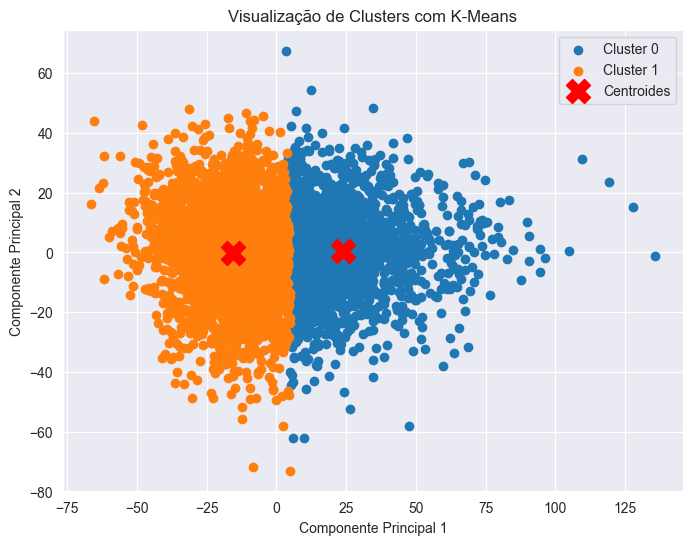

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Adicionar rótulos de cluster
labels = kmeans.labels_

# Reduzir dimensionalidade para 2D com PCA
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_imputed)

# Visualização
plt.figure(figsize=(8, 6))
for cluster_id in range(n_clusters):
    # Filtrar os pontos pertencentes ao cluster atual
    cluster_points = X_train_2D[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")

# Centroides
centroids_2D = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], s=300, c='red', marker='X', label="Centroides")

# Configurações do gráfico
plt.title("Visualização de Clusters com K-Means")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(True)
plt.show()


Pontuação média da silhueta: 0.17


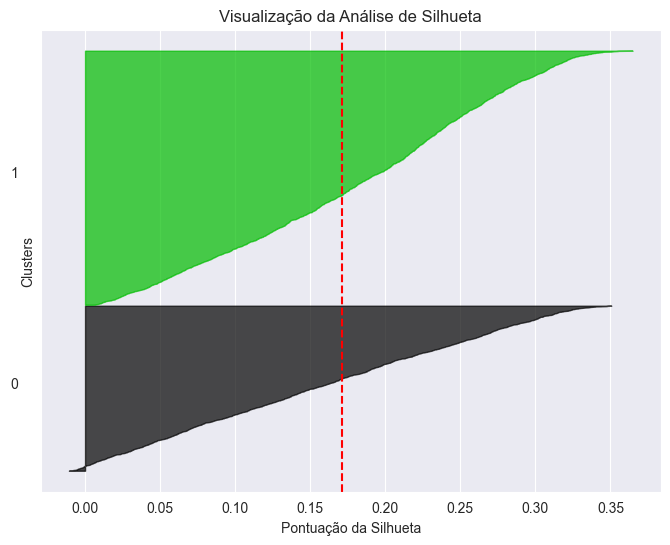

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_clusters = 2

# Calcular a pontuação média da silhueta
silhouette_avg = silhouette_score(X_train_imputed, labels)
print(f"Pontuação média da silhueta: {silhouette_avg:.2f}")

# Calcular a pontuação da silhueta para cada amostra
sample_silhouette_values = silhouette_samples(X_train_imputed, labels)

# Visualizar as pontuações da silhueta
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
for i in range(n_clusters):
    # Filtrar as pontuações da silhueta para o cluster atual
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Plotar as pontuações da silhueta para o cluster
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Ajustar o espaço entre os clusters

# Configurações do gráfico
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Visualização da Análise de Silhueta")
ax.set_xlabel("Pontuação da Silhueta")
ax.set_ylabel("Clusters")
ax.set_yticks([])  # Sem marcas no eixo Y
ax.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Defina o número de clusters (exemplo: 2 classes alvo)
n_clusters = 2

# Crie o modelo K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Aplique K-Means nos dados de treinamento imputados
kmeans.fit(X_Test_imputed)

# Adicione os rótulos de clusters aos dados imputados
X_test_clustered = pd.DataFrame(X_Test_imputed, columns=[f"feature_{i}" for i in range(X_Test_imputed.shape[1])])
X_test_clustered['cluster'] = kmeans.labels_

# Visualize os resultados do agrupamento
print(X_test_clustered.head())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0        7.0        1.0  72.000000       72.0        1.0        1.0   
1        4.0        1.0  81.000000       81.0        1.0        1.0   
2        8.0        1.0  77.000000       77.0        2.0        1.0   
3       11.0        1.0  58.000000       58.0        1.0        1.0   
4        5.0        2.0  65.466667       67.0        5.0        2.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_177  feature_178  \
0      162.0      162.0        0.0        2.0  ...          2.0          2.0   
1      168.0      168.0        0.0        2.0  ...          2.0          2.0   
2      165.0      165.0        0.0        2.0  ...          1.0          2.0   
3      170.0      170.0        0.0        2.0  ...          2.0          2.0   
4      153.5      151.0        1.0        2.0  ...          2.0          2.0   

   feature_179  feature_180  feature_181  feature_182  feature_183  \
0          2.0        

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_train_imputed)


# Passo 1: Dados de entrada (X) e rótulos dos clusters (labels como y)
X = X_train_imputed  # Atributos
y = labels  # Rótulos dos clusters gerados

# Passo 2: Divida os dados em treino e teste (opcional, para validação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Treine a árvore de decisão
clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Limite a profundidade para simplificar
clf.fit(X_train, y_train)

# Passo 4: Avalie a precisão (opcional)
accuracy = clf.score(X_Test_imputed, y_test)
print(f"Acurácia da árvore no conjunto de teste: {accuracy:.2f}")

# Passo 5: Visualize a árvore (como texto)
tree_rules = export_text(clf, feature_names=[f"Feature {i}" for i in range(X.shape[1])])
print(tree_rules)

# Passo 6: Visualize a árvore graficamente
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=[f"Feature {i}" for i in range(X.shape[1])],
               class_names=[f"Cluster {i}" for i in range(len(set(y)))], filled=True)
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [943, 32714]

Pontuação média da silhueta: 0.18


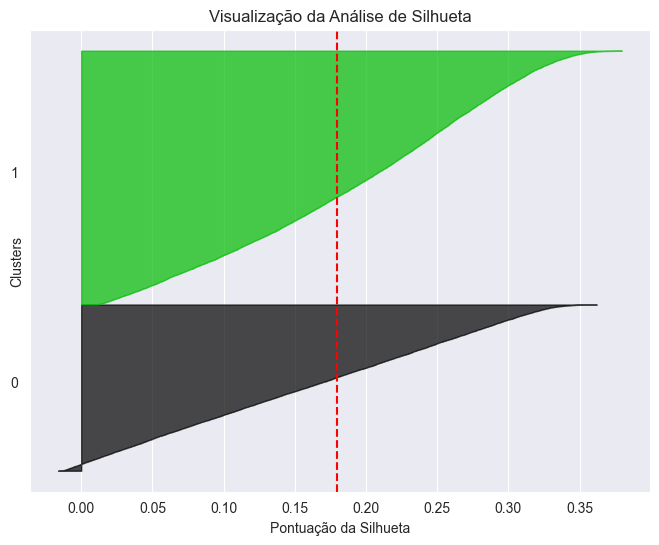

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configurar o número de clusters (usando o mesmo kmeans ajustado anteriormente)
n_clusters = 2

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_Test_imputed)

# Calcular a pontuação média da silhueta
silhouette_avg = silhouette_score(X_Test_imputed, labels)
print(f"Pontuação média da silhueta: {silhouette_avg:.2f}")

# Calcular a pontuação da silhueta para cada amostra
sample_silhouette_values = silhouette_samples(X_Test_imputed, labels)

# Visualizar as pontuações da silhueta
fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
for i in range(n_clusters):
    # Filtrar as pontuações da silhueta para o cluster atual
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Plotar as pontuações da silhueta para o cluster
    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Ajustar o espaço entre os clusters

# Configurações do gráfico
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_title("Visualização da Análise de Silhueta")
ax.set_xlabel("Pontuação da Silhueta")
ax.set_ylabel("Clusters")
ax.set_yticks([])  # Sem marcas no eixo Y
ax.grid(True)
plt.show()

Acurácia da árvore no conjunto de teste: 0.95
|--- Feature 2 <= 76.92
|   |--- Feature 2 <= 72.92
|   |   |--- Feature 6 <= 178.25
|   |   |   |--- class: 1
|   |   |--- Feature 6 >  178.25
|   |   |   |--- class: 1
|   |--- Feature 2 >  72.92
|   |   |--- Feature 6 <= 167.42
|   |   |   |--- class: 1
|   |   |--- Feature 6 >  167.42
|   |   |   |--- class: 0
|--- Feature 2 >  76.92
|   |--- Feature 2 <= 80.58
|   |   |--- Feature 6 <= 162.75
|   |   |   |--- class: 1
|   |   |--- Feature 6 >  162.75
|   |   |   |--- class: 0
|   |--- Feature 2 >  80.58
|   |   |--- Feature 7 <= 152.50
|   |   |   |--- class: 0
|   |   |--- Feature 7 >  152.50
|   |   |   |--- class: 0



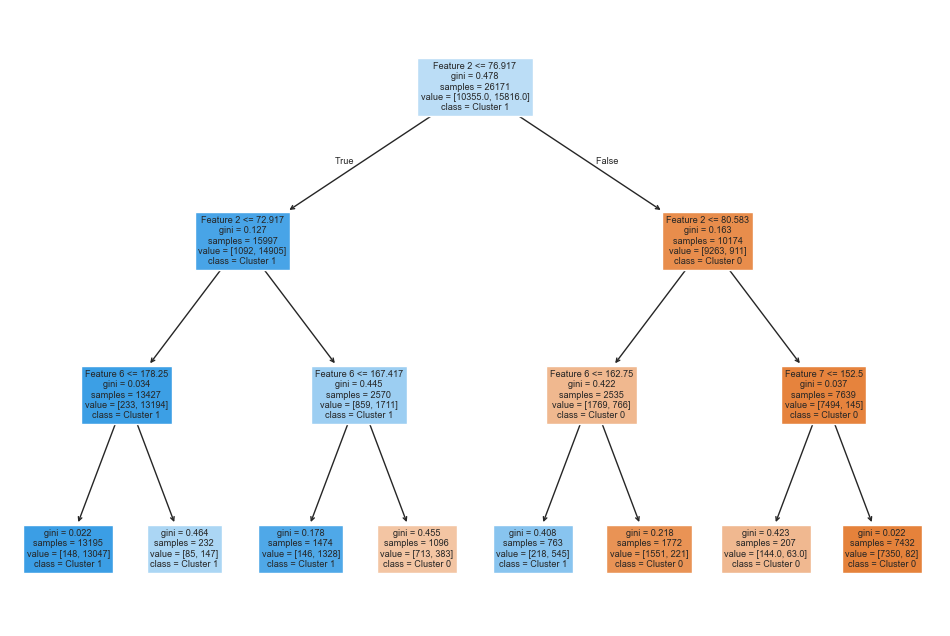

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import tree

# Passo 1: Dados de entrada (X) e rótulos dos clusters (labels como y)
X = X_Test_imputed  # Atributos
y = labels          # Rótulos dos clusters gerados

# Passo 2: Divida os dados em treino e teste (opcional, para validação)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Treine a árvore de decisão
clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Limite a profundidade para simplificar
clf.fit(X_train, y_train)

# Passo 4: Avalie a precisão (opcional)
accuracy = clf.score(X_test, y_test)
print(f"Acurácia da árvore no conjunto de teste: {accuracy:.2f}")

# Passo 5: Visualize a árvore (como texto)
tree_rules = export_text(clf, feature_names=[f"Feature {i}" for i in range(X.shape[1])])
print(tree_rules)

# Passo 6: Visualize a árvore graficamente
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=[f"Feature {i}" for i in range(X.shape[1])], class_names=[f"Cluster {i}" for i in range(len(set(y)))], filled=True)
plt.show()


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Melhores hiperparâmetros encontrados:
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}

Acurácia com melhores hiperparâmetros: 0.6950206833154589

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.06      0.66      0.11       928
           1       0.99      0.70      0.82     31707

    accuracy                           0.70     32635
   macro avg       0.52      0.68      0.46     32635
weighted avg       0.96      0.70      0.80     32635



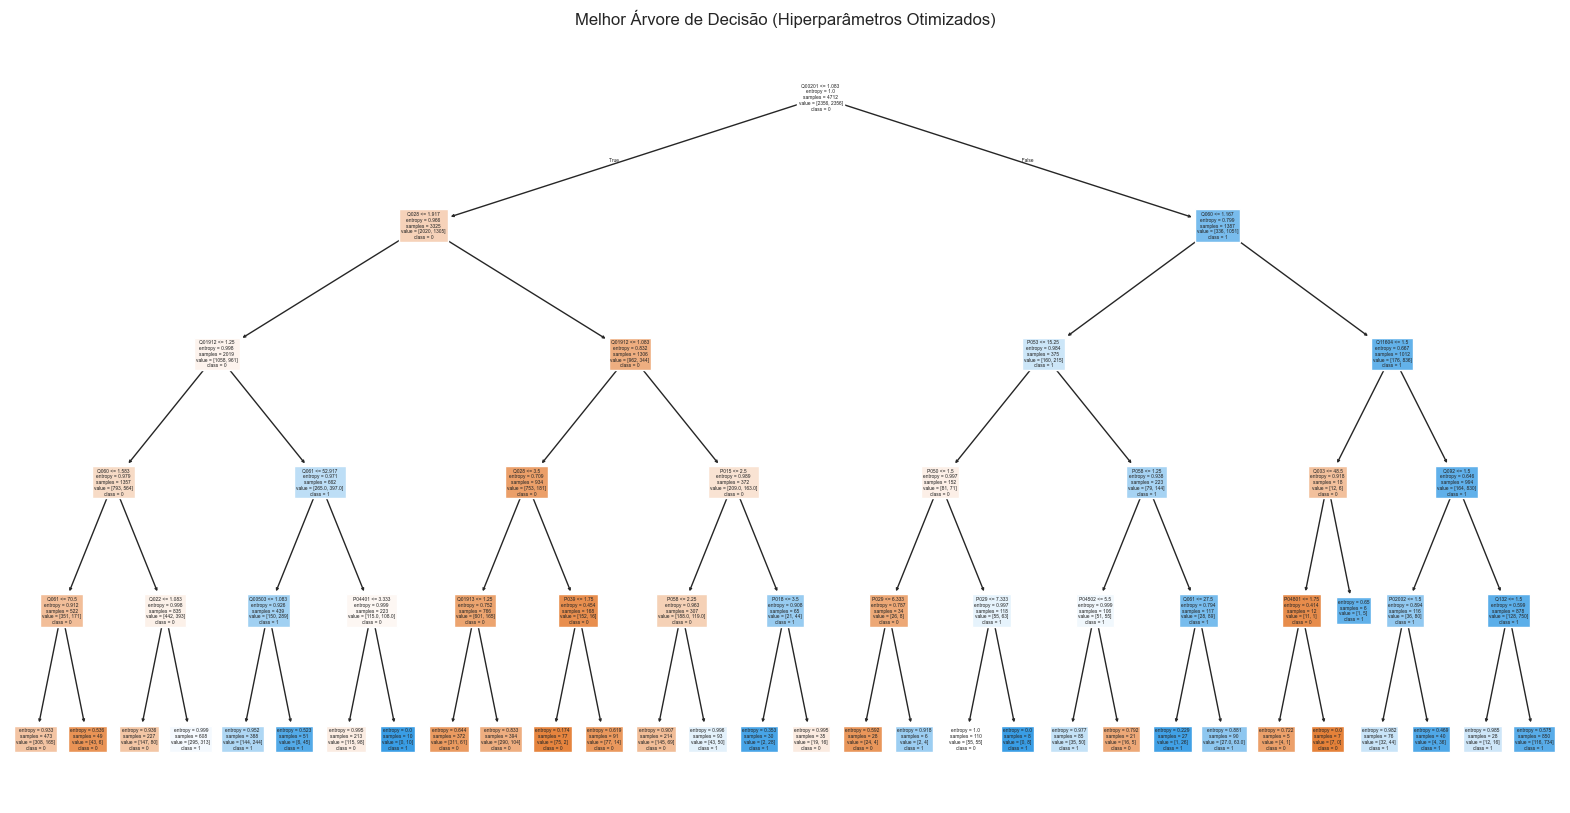

In [ ]:
# Importar bibliotecas necessárias
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score
from sklearn.tree import plot_tree
# Definição do modelo base
clf = DecisionTreeClassifier(random_state=42)

# Definir o espaço de busca para os hiperparâmetros
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Funções de avaliação
    'max_depth': [None, 3, 5, 10, 20],             # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],               # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 5],                 # Mínimo de amostras em cada folha
    'class_weight': [None, {0: 1, 1: 1}, {0: 2, 1: 1}, {0: 1, 1: 2}],  # Pesos para as classes
}

# Configurar o Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',  # Pode ajustar para 'f1', 'roc_auc', etc., dependendo do objetivo
    cv=5,                # Validação cruzada com 5 folds
    verbose=2,           # Exibe o progresso
    n_jobs=-1            # Usa todos os processadores disponíveis
)

# Realizar a busca pelos melhores hiperparâmetros
grid_search.fit(X_train_imputed, y_resampled)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

# Treinar o modelo com os melhores parâmetros
best_clf = grid_search.best_estimator_

# Avaliar o modelo nos dados de teste
y_pred = best_clf.predict(X_Test_imputed)
print("\nAcurácia com melhores hiperparâmetros:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred))

# Visualizar a melhor árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    filled=True,
    feature_names=X_resampled.columns.astype(str).tolist(),  # Ajustar nomes das features
    class_names=best_clf.classes_.astype(str).tolist()       # Ajustar nomes das classes
)
plt.title("Melhor Árvore de Decisão (Hiperparâmetros Otimizados)")
plt.show()

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

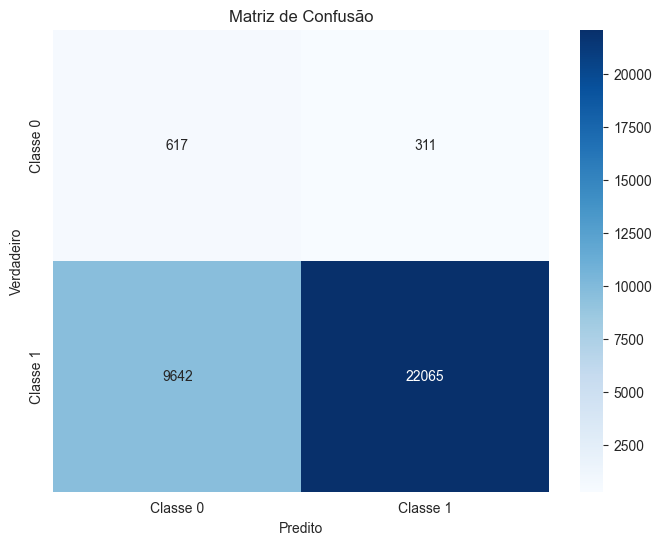

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()